<h1 style="font-size: 42px; text-align: center;">HW5: Monte Carlo Tree Search and Naive Search</h1>

> **Full Name:** `Ayeen Poostforoushan`
> **Student ID:** `401105742`

<p align="center">
    <a href="https://colab.research.google.com/github/DeepRLCourse/Homework-5-Questions/blob/main/RL_HW5_MCTS.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
    </a>
    <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Homework-5-Questions/main/RL_HW5_MCTS.ipynb">
        <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle">
    </a>
</p>

---

## 📌 Overview

Welcome to **HW5**, where you will explore and implement search algorithms in reinforcement learning!  
In this assignment, you will:

✅ Implement **Monte Carlo Tree Search (MCTS)** and a **Naive Search Algorithm**.  
✅ Develop an agent that utilizes these techniques for decision-making.  
✅ Test and evaluate the performance of your agent.  

### 📂 Notebook Structure:
1️⃣ **Environment Definition**  
2️⃣ **Search Algorithms: Naive Search & MCTS**  
3️⃣ **Agent Implementation**  
4️⃣ **Training & Testing Loop**  

💡 *Each section includes explanations, docstrings, and `TODO` placeholders for missing implementations. Fill in the gaps and complete the assignment!*  

🚀 *Let's get started!*  


# Detailed Explanation of the Overall Algorithm

This notebook implements a MuZero-like approach to reinforcement learning, as described in the paper  
[“Mastering Atari, Go, Chess and Shogi by Planning with a Learned Model” (Schrittwieser et al., 2019)](https://arxiv.org/abs/1911.08265).  
Below is an overview of the key components and how they work together:

---

## 1. Representation, Dynamics, and Prediction Networks

MuZero (and algorithms inspired by it) relies on three core neural networks:

1. **Representation Network (`RepresentationNet`)**  
   - **Goal**: Convert raw observations (e.g., game frames, board states) into a latent (hidden) state.  
   - **Why It Matters**: By encoding high-dimensional inputs (like pixel images) into a more compact form, downstream modules can operate efficiently on this latent space rather than the raw data.

2. **Dynamics Network (`DynamicsNet`)**  
   - **Goal**: Given the current hidden state and an action, predict the **next hidden state** and an **immediate reward estimate**.  
   - **Why It Matters**: This is the “model” portion of MuZero. It simulates how the hidden state changes when an action is taken, letting the algorithm plan forward without needing a hand-crafted or perfect simulator.

3. **Prediction Network (`PredictionNet`)**  
   - **Goal**: From a hidden state, predict:
     1. **A policy distribution** (probabilities of selecting each possible action)
     2. **A value estimate** (scalar measure of how good or bad the state is)  
   - **Why It Matters**: This guides the search and learning, telling us which actions are promising (policy) and how favorable the current position might be (value).

---

## 2. Monte Carlo Tree Search (MCTS) and Naive Depth Search

1. **Monte Carlo Tree Search (`MCTS` Class)**  
   - **Core Idea**: Repeatedly simulate many “what if?” scenarios (rollouts) to gather statistics on which actions lead to higher value.  
   - **Key Methods**:  
     - `run(...)`: Manages the entire search process from the root hidden state.  
     - `_expand_node(...)`: Expands a leaf node by calling the dynamics and prediction networks.  
     - `_backpropagate(...)`: Propagates the newly obtained value estimates back up the search path.  
     - `_calc_ucb(...)`: Calculates an Upper Confidence Bound (UCB) score to balance exploration (trying new actions) and exploitation (using known good actions).  
     - `_compute_pi()`: Aggregates the visit counts of each child action at the root to form a final policy distribution.  

2. **Naive Depth Search (`naive_depth_search(...)`)**  
   - **Core Idea**: Look ahead a fixed depth in a brute-force manner, expanding all action sequences up to that depth.  
   - **Why It Matters**: Though less sophisticated than MCTS, it offers a simpler example of planning. It enumerates action branches, accumulates rewards and discounted values, and then picks the best sequence.

---

## 3. Buffer Replay

- **Purpose**: Store entire trajectories (episodes) of experience, then allow sampling of smaller segments (sub-trajectories) for training.  
- **How**:  
  1. **`add_trajectories(...)`**: Inserts full episodes into the buffer.  
  2. **`sample_sub_trajectory(...)`**: Retrieves a sub-trajectory of length `k` (for an n-step return) from the stored episodes.  
  3. **`sample_batch(...)`**: Returns a batch of sub-trajectories for training the neural networks.  

---

## 4. Agent

- **Role**: Central coordinator that uses the networks (Representation, Dynamics, Prediction) and search algorithms (MCTS or naive) to choose actions.  
- **Key Functions**:
  1. **`inference(...)`**: Given an observation, the agent converts it to a hidden state, then either:
     - Runs MCTS to derive a policy (if `search_type="mcts"`)
     - Performs a naive depth search (if `search_type="naive"`)
     - Or uses the direct policy from the `PredictionNet` (if no search is enabled)  
    The chosen action, along with the policy distribution and value estimate, is returned.
  2. **`initial_step(...)`**: Processes the initial raw observation into a hidden state and then obtains policy/value estimates.  
  3. **`rollout_step(...)`**: Given a hidden state plus actions, calls the `DynamicsNet` to get the next hidden state and reward, and the `PredictionNet` to predict policy/value at that new state.

---

## 5. Overall Training Procedure

1. **Collect Trajectories**:  
   - The agent interacts with the environment, using either MCTS or naive search to pick actions.  
   - The environment returns observations/rewards that form trajectories (episodes).

2. **Store in Replay**:  
   - These full trajectories are added to the `BufferReplay`.

3. **Sample Mini-Batches**:  
   - The training script samples sub-trajectories from the buffer (via `sample_sub_trajectory(...)` or `sample_batch(...)`).

4. **Unroll the Model**:  
   - For each sampled sub-trajectory, the code unrolls the networks (`RepresentationNet`, `DynamicsNet`, `PredictionNet`) for multiple steps (up to `k`) to compare the model’s predictions to the actual transitions.

5. **Compute Loss & Update**:  
   - The total loss typically includes terms for:
     - **Value error** (predicted vs. actual return)
     - **Policy error** (predicted policy vs. search-derived/improved policy)
     - **Reward error** (predicted vs. actual immediate reward)  
   - Backpropagation updates the parameters of all three networks end-to-end.

6. **Repeat**:  
   - Continue this cycle of data collection and network updates until convergence.

## Library Imports

In [1]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import math

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
##############################################
# Environment Runner
##############################################
class EnvironmentRunner:
    """
    Manages interactions with an OpenAI Gym environment:
    - Resets the environment
    - Steps through it given an agent's actions
    - Logs returns and gathers trajectory data
    """

    def __init__(self, gym_env):
        self.gym_env = gym_env
        self.num_actions = self.gym_env.action_space.n

        self.observation = self.gym_env.reset()
        self.episodes_count = 0


    def run(self, agent, show_render=False):
            """
            Runs one full episode:
            1) Resets environment
            2) Steps until done
            3) Logs returns
            4) Returns the collected trajectory
            """
            obs_list = []
            actions_list = []
            rewards_list = []
            done_list = []
            policy_list = []
            values_list = []

            # initial reset
            self.observation = self.gym_env.reset()
            obs_list.append(torch.tensor(self.observation))

            finished = False
            while not finished:
                # Let agent infer the next action
                chosen_action, distribution, val_est = agent.inference(
                    torch.tensor(self.observation, dtype=dtype, device=device)
                )

                next_obs, reward, finished, info = self.gym_env.step(chosen_action)

                # Store
                obs_list.append(torch.tensor(next_obs))
                actions_list.append(chosen_action)
                policy_list.append(torch.tensor(distribution))
                values_list.append(val_est)
                rewards_list.append(torch.tensor(reward))
                done_list.append(finished)

                # Optional render
                if show_render:
                    self.gym_env.render()
                    time.sleep(0.024)

                self.observation = next_obs

            self.episodes_count += 1
            return self.build_trajectory(obs_list, actions_list, rewards_list, done_list, policy_list, values_list)

    @staticmethod
    def build_trajectory(obs, acts, rews, finished_flags, pols, vals):
        return {
            "obs": obs,
            "actions": acts,
            "rewards": rews,
            "dones": finished_flags,
            "pis": pols,
            "vs": vals,
            "length": len(obs)
        }
        
class LoggingEnvRunner(EnvironmentRunner):
    """
    Extends EnvironmentRunner to log episode returns.
    """
    def __init__(self, env):
        super().__init__(env)
        self.episode_returns = []

    def run(self, agent):
        trajectory = super().run(agent)  # normal run
        # Summation of the episode's rewards:
        ep_return = float(np.sum(trajectory["rewards"]))
        self.episode_returns.append(ep_return)
        return trajectory

In [4]:
##############################################
# A simple Gym Wrapper
##############################################
class GymWrapper(gym.Wrapper):
    """
    A wrapper that folds multiple historical observations
    into a single stacked observation.
    """

    def __init__(self, env, history_len):
        super().__init__(env)
        self.history_len = history_len
        self.obs_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n

    def reset(self):
        self.episode_return = 0
        self.observations_rollout = []

        obs = self.env.reset()
        self.observations_rollout.append(obs)

        return self.aggregate()

    def aggregate(self):
        """
        Stacks the last N observations (with possible zero-padding).
        Returns them as a flattened array of shape (1, -1).
        """
        stacked = np.zeros((self.history_len, self.obs_dim))

        current_length = len(self.observations_rollout)
        if current_length == self.history_len:
            stacked = np.array(self.observations_rollout)
        else:
            stacked[self.history_len - current_length :] = np.array(
                self.observations_rollout
            )

        return stacked.flatten().reshape(1, -1)

    def step(self, action):
        next_obs, reward, done, info = self.env.step(action)
        self.update_history(next_obs)
        aggregated_obs = self.aggregate()

        self.episode_return += reward
        if done:
            info["return"] = self.episode_return

        return aggregated_obs, reward, done, info

    def update_history(self, new_obs):
        if len(self.observations_rollout) == self.history_len:
            # drop oldest
            self.observations_rollout = self.observations_rollout[1:]
        self.observations_rollout.append(new_obs)

# `BufferReplay` Class

This class manages a replay buffer for reinforcement learning, specifically storing entire trajectories (episodes). It supports two main operations:

1. **Storing Trajectories**:  
   - `add_trajectories(new_trajectories)`: Appends new trajectories to the buffer. If the capacity is exceeded, it overwrites old trajectories in a circular manner.

2. **Sampling Sub-Trajectories**:  
   - `sample_sub_trajectory(k, n, discount)`: Randomly selects a single trajectory from the buffer, chooses a random start index within that trajectory, and extracts a sub-trajectory of length `k` for training. It also computes an `n`-step return for each step in the sub-trajectory, taking into account the discount factor.  
   - `sample_batch(batch_size, k, n, discount)`: Repeats the above sub-trajectory sampling multiple times to form a training batch.

## Data Structure Returned by `sample_sub_trajectory`

`sample_sub_trajectory` returns a dictionary with the following keys:

- **"obs"**: The observation at the starting point of the sub-trajectory.  
  - Type/Shape: Typically a tensor (or array) representing the state.  
- **"pi"**: A list of policy distributions (one per timestep in the sub-trajectory).  
  - Type/Shape: Each entry is usually a tensor of shape `(num_actions,)`, giving the probability distribution over actions.  
- **"v"**: (If included in your design) a list of value estimates for each step in the sub-trajectory.  
  - Type/Shape: Each entry could be a tensor of shape `(1,)` or just a single scalar representing the value.  
- **"actions"**: A list of integers (or tensors) indicating which action was taken at each step.  
  - Type/Shape: Each entry typically an integer in the range `[0, num_actions-1]`.  
- **"rewards"**: A list of rewards obtained for each step in the sub-trajectory.  
  - Type/Shape: Each entry is typically a scalar tensor (or float).  
- **"return"**: A list of n-step returns corresponding to each timestep in the sub-trajectory.  
  - Type/Shape: Each entry is usually a scalar tensor (or float) representing the discounted sum of rewards plus a discounted bootstrap value.

Overall, this dictionary encapsulates all the necessary data (observation, actions, rewards, policy, value, returns) for training, allowing algorithms to perform n-step updates or other forms of training that depend on short sequences of experience.


In [5]:
##############################################
# Buffer Replay (Experience)
##############################################
class BufferReplay:
    """
    Stores entire episodes (trajectories), then allows sampling
    sub-portions for training (k-step unroll & n-step return).
    """

    def __init__(self, capacity, num_actions):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.num_actions = num_actions

    def add_trajectories(self, new_trajectories):
        """
        Inserts new trajectories (episodes) into the memory buffer.

        Detailed Functionality:
        -----------------------
        1. Iterates over each trajectory in `new_trajectories`.
        2. If the buffer is not yet at `capacity`, append the new trajectory.
        3. If at capacity, overwrite the oldest trajectory in a circular manner.
        4. Updates the internal `position` pointer accordingly.

        Parameters:
        -----------
        new_trajectories : list
            A list of trajectory dictionaries, each containing keys like:
            - "obs": list of observations
            - "actions": list of actions
            - "rewards": list of rewards
            - "pis": list of policy distributions
            - "vs": list of value estimates (if present)
            - "length": an integer specifying the number of timesteps

        TODO:
        -----
        Your code
        """
        for trajectory in new_trajectories:
            if len(self.memory) < self.capacity:
                self.memory.append(trajectory)
            else:
                self.memory[self.position] = trajectory
            self.position = (self.position + 1) % self.capacity

    def sample_sub_trajectory(self, k, n, discount):
        """
        Randomly picks a single stored trajectory and a start index,
        returning k-step unroll data plus n-step returns.

        Detailed Functionality:
        -----------------------
        1. Selects a random trajectory from the stored buffer.
        2. Chooses a random start index within that trajectory.
        3. Unrolls for `k` steps to gather:
           - Observations
           - Actions
           - Rewards
           - Policy distributions
        4. Computes the n-step return for each of these k steps:
           - Sums the discounted rewards
           - May add a bootstrap value if within bounds of the trajectory
        5. Handles out-of-bounds cases where the unroll extends beyond
           the trajectory length, using padding or default values where necessary.

        Parameters:
        -----------
        k : int
            The number of timesteps to unroll the environment from the chosen start index.
        n : int
            The n-step horizon for return calculation.
        discount : float
            The discount factor used for return computation.

        Returns:
        --------
        dict
            A dictionary with keys:
            - "obs": The initial observation at the start index.
            - "pi": List of policy distributions for each step (length `k+1`).
            - "v": (Optional, if your code includes it) List of value estimates per step.
            - "actions": List of actions taken (length `k+1`, including potential padding).
            - "rewards": List of rewards for each step in the unroll (length `k`).
            - "return": A list of computed n-step returns (length `k+1`).
        """
        
        data = {
            "obs": None,
            "pi": [],
            "v": [],
            "actions": [],
            "rewards": [],
            "return": [],
        }

        # Choose a random trajectory
        mem_idx = np.random.choice(len(self.memory), 1)[0]
        chosen_length = self.memory[mem_idx]["length"]
        last_idx = chosen_length - 1

        # Random start
        start = np.random.choice(chosen_length, 1)[0]

        # We'll record the initial observation
        data["obs"] = self.memory[mem_idx]["obs"][start]

        # Collect data for each unroll step
        for step in range(start, start + k + 1):
            lookahead = step + n

            # If looking beyond trajectory end, v_n = 0
            if lookahead >= last_idx:
                future_value = torch.tensor([0.0], device=device, dtype=dtype)
            else:
                future_value = torch.tensor(self.memory[mem_idx]["vs"][lookahead] * (discount**n), dtype=dtype).to(device)

            # sum of discounted rewards up to n or end
            total_val = future_value.clone()
            max_reward_idx = min(last_idx, lookahead)
            enumer_rewards = list(
                enumerate(self.memory[mem_idx]["rewards"][step:max_reward_idx])
            )
            for i, single_r in enumer_rewards:
                total_val += single_r * (discount**i)

            data["return"].append(total_val)

            # Not storing reward for the very initial step in the unroll
            if step != start:
                if 0 < step <= last_idx:
                    data["rewards"].append(self.memory[mem_idx]["rewards"][step - 1])
                else:
                    data["rewards"].append(torch.tensor([0.0], device=device))

            # Pi distribution
            if 0 <= step < last_idx:
                data["pi"].append(self.memory[mem_idx]["pis"][step])
            else:
                # In case we are beyond the real trajectory
                uniform_probs = np.ones(self.num_actions) / self.num_actions
                data["pi"].append(torch.tensor(uniform_probs, dtype=dtype))

        # Build the real set of actions from the actual trajectory
        max_valid_step = min(last_idx - 1, start + k - 1)
        num_steps_valid = max_valid_step - start
        data["actions"] = self.memory[mem_idx]["actions"][
            start : start + num_steps_valid + 1
        ]

        # Fill with random actions if we unroll beyond the stored trajectory
        fill_count = k - num_steps_valid + 1
        for _ in range(fill_count):
            rand_act = np.random.choice(self.num_actions, 1)[0]
            data["actions"].append(rand_act)

        return data

    def sample_batch(self, batch_size, k, n, discount=0.99):
        """
        Returns a batch (list) of sub trajectories. Each item
        in the batch has the keys: obs, pi, v, actions, rewards, return

        Parameters:
        -----------
        batch_size : int
            Number of sub-trajectories to sample.
        k : int
            Number of unroll steps in each sub-trajectory.
        n : int
            Horizon for n-step return.
        discount : float
            Discount factor.

        Returns:
        --------
        list
            A list of dictionaries, each containing sub-trajectory data
            (with the same keys as described in `sample_sub_trajectory`).
        """

        batch_data = []
        for _ in range(batch_size):
            sample = self.sample_sub_trajectory(k, n, discount)
            batch_data.append(sample)
        return batch_data

    def __len__(self):
        """
        Returns the current number of stored trajectories in memory.
        """
        return len(self.memory)


# Representation, Dynamics, and Prediction Models

These three neural network classes (`RepresentationNet`, `DynamicsNet`, `PredictionNet`) work together to model different aspects of an environment in a reinforcement learning (RL) setting, often inspired by algorithms like MuZero or similar approaches.

1. **`RepresentationNet`**  
   - **Goal**: Transform a raw observation (from the environment) into a **hidden state** vector.  
   - **Role in RL**: This hidden state often serves as a compact, learned representation of the environment’s information and is used by subsequent models (such as `DynamicsNet` and `PredictionNet`) to make predictions about future states, rewards, policies, and values.

2. **`DynamicsNet`**  
   - **Goal**: Predict the **next hidden state** and **immediate reward** from the **current hidden state** and an encoded action.  
   - **Role in RL**: This allows a learning algorithm to “imagine” how the environment transitions forward without directly querying the real environment, enabling planning and lookahead.

3. **`PredictionNet`**  
   - **Goal**: Given a hidden state, output a **policy** (probability distribution over possible actions) and a **value estimate** (scalar).  
   - **Role in RL**:  
     - The **policy** guides action selection, telling us which actions might be best at each timestep.  
     - The **value estimate** helps evaluate how good or bad a particular state is, assisting with learning.

## Form of the Desired Outputs
- **`RepresentationNet`**:  
  Outputs a **hidden state** tensor of shape `(batch_size, hidden_dim)`.
- **`DynamicsNet`**:  
  Outputs two tensors:  
  1. **Next hidden state** of shape `(batch_size, hidden_dim)`  
  2. **Reward estimate** of shape `(batch_size,)`
- **`PredictionNet`**:  
  Outputs two tensors:  
  1. **Policy** of shape `(batch_size, num_actions)`, representing a probability distribution over actions.  
  2. **Value** of shape `(batch_size,)`, representing a scalar estimate of the state value.


In [6]:
##############################################
# Representation, Dynamics, Prediction models
##############################################
class RepresentationNet(nn.Module):
    """
    Maps an environment observation into a hidden state.

    In Detail:
    ----------
    This network transforms a raw input observation (e.g., states, images, or other features)
    into a latent or hidden state representation that captures the essential information.

    Form of Output:
    ---------------
    - A hidden state tensor of shape (batch_size, hidden_dim).
    """

    def __init__(self, input_dim, hidden_dim):
        """
        Initializes layers required to convert `input_dim` features
        into a `hidden_dim`-dimensional vector.
        """
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, hidden_dim),
            nn.ReLU(),
        )
        

    def forward(self, x):
        """
        Forward pass that takes a batch of observations `x` and
        returns the corresponding hidden state representation.
        """
        # Pass through the network
        return self.network(x)


class DynamicsNet(nn.Module):
    """
    Predicts the next hidden state and immediate reward
    from the current hidden state and action encoding.

    In Detail:
    ----------
    Given a current hidden state and an action, this network outputs:
    - Next hidden state (shape: (batch_size, hidden_dim))
    - A scalar reward estimate (shape: (batch_size,))

    The action is typically encoded as a one-hot or scalar that the network
    incorporates as part of the input layer.
    """

    def __init__(self, hidden_dim, action_space):
        """
        Initializes layers that combine `hidden_dim` features and
        an encoded action to produce the next hidden state and reward.
        """
        super().__init__()
        self.hid1 = nn.Linear(hidden_dim + action_space, 128)
        self.dropout = nn.Dropout(0.1)
        self.hidden_fc = nn.Linear(128, hidden_dim)
        self.reward_fc = nn.Linear(hidden_dim, 1)


    def forward(self, hidden_layer):
        """
        Forward pass that takes a batch consisting of the current hidden state
        and the encoded action, returning the next hidden state and reward estimate.
        """
        hidden_layer = self.hid1(hidden_layer)
        hidden_layer = F.relu(hidden_layer)
        hidden_layer = self.dropout(hidden_layer)
        next_hidden_state = self.hidden_fc(hidden_layer)
        next_hidden_state = F.relu(next_hidden_state)
        reward = self.reward_fc(next_hidden_state).squeeze(-1)
        return next_hidden_state, reward


class PredictionNet(nn.Module):
    """
    Given a hidden state, outputs:
      - A policy distribution (size = num_actions)
      - A scalar value estimate (size = 1 per batch item)

    In Detail:
    ----------
    The model reads the hidden state (shape: (batch_size, hidden_dim)) and produces:
    - `policy`: A probability distribution over actions (shape: (batch_size, num_actions)).
    - `value`: A scalar estimate for each hidden state (shape: (batch_size,)).
    """

    def __init__(self, hidden_dim, num_actions):
        """
        Initializes layers to map a hidden state into policy logits
        (of length `num_actions`) and a scalar value estimate.
        """
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, num_actions + 1),
        )

    def forward(self, hidden_x):
        """
        Forward pass that takes a batch of hidden states `hidden_x`
        and produces the policy distribution and value estimate.
        """
        net_output = self.network(hidden_x)
        value_estimate = net_output[:, -1]
        policy_logits = net_output[:, :-1]
        policy = F.softmax(policy_logits, dim=-1)
        return policy, value_estimate
        


# MCTS And Naive Depth-Based Search

In this section, we have several classes and functions that support Monte Carlo Tree Search (MCTS) and a naive depth-based search approach:

1. **`AdaptiveNormalizer`**  
   - Tracks the running minimum and maximum values of inputs (e.g., Q-values).  
   - Allows for on-the-fly normalization of these values, which can stabilize the search process.

2. **`TreeNode`**  
   - Represents a node in the MCTS search tree.  
   - Stores statistics such as visit counts, the sum of value estimates, child edges, and prior probabilities.  
   - The node can also store a hidden state representation and an estimated reward for transitioning from a parent node.

3. **`MCTS` Class**  
   - Controls the MCTS search process.  
   - Contains key methods like `run`, `_expand_node`, `_backpropagate`, `_calc_ucb`, and `_compute_pi` for performing MCTS simulations, updating node statistics, and calculating action visit distributions.  
   - Uses a dynamics model and prediction model to simulate the environment forward and estimate policies/values.

4. **`naive_depth_search` Function**  
   - Demonstrates a simpler (but inefficient) depth-based search.  
   - Expands all actions up to a certain depth, computes rewards and leaf values, then picks the action sequence with the highest total return.

## Form of the Desired Outputs

- **`AdaptiveNormalizer`**:  
  - Provides two primary methods: `update(val)` to update min/max stats and `normalize(val)` to scale values into a normalized range.

- **`TreeNode`**:  
  - Stores `edges` mapping each possible action to another `TreeNode`.  
  - Maintains `avg_value` (the mean of all values backpropagated through it), `visit_count`, and `total_value_sum`.  
  - It may store `state_rep` (the current hidden state representation) and `reward_est` (the immediate reward from the parent node to itself).

- **`MCTS`**:  
  1. **`run(sims_count, root_state)`**:  
     - Orchestrates the entire MCTS procedure for a given number of simulations (`sims_count`).  
     - Returns the **visit counts** over actions (used to derive a policy) and the **average value** of the root node.  
  2. **`_expand_node(parent_node, new_node, chosen_action)`**:  
     - Expands the leaf node by calling the environment (or model) with a chosen action, obtaining the next hidden state, policy, value, and reward.  
     - Creates children edges for all possible actions from the new state.  
     - Returns the new value estimate for further backpropagation.  
  3. **`_backpropagate(leaf_value)`**:  
     - Starts at the leaf node and moves backward through the search path, updating each node’s visit count and total value sum with the discounted reward.  
  4. **`_calc_ucb(parent, child)`**:  
     - Calculates the Upper Confidence Bound (UCB) score for a given child node.  
     - Uses the node’s prior probability, visit counts, and normalized value estimates to balance exploration and exploitation.  
     - Returns a scalar score that can be used to pick the best child action.  
  5. **`_compute_pi()`**:  
     - Aggregates the visit counts for each action at the root node, which can be used as an approximate policy distribution.

- **`naive_depth_search`**:  
  - Explores every possible action combination up to a specified depth (`search_depth`).  
  - Accumulates reward and discounted values, then selects the best action path found.


In [7]:
##############################################
# MCTS Classes
##############################################
class AdaptiveNormalizer:
    """
    Simple min-max normalizer that tracks running min/max
    so we can scale Q-values in MCTS.

    Form of Operation:
    ------------------
    - Tracks the minimum and maximum values observed so far.
    - After each update, incoming values can be scaled to [0,1].
    """

    def __init__(self):
        self.max_val = float("-inf")
        self.min_val = float("inf")

    def update(self, val):
        """
        Updates the running minimum and maximum with the new value.

        Parameters:
        -----------
        val : torch.Tensor
            The new value for which we update min/max stats.
        """
        val_cpu = val.cpu()
        self.max_val = max(self.max_val, val_cpu)
        self.min_val = min(self.min_val, val_cpu)

    def normalize(self, val):
        """
        Scales the given value into the [0,1] range based on current min/max.

        Parameters:
        -----------
        val : torch.Tensor
            The value to be normalized.

        Returns:
        --------
        torch.Tensor
            The normalized value in [0,1] if max_val > min_val,
            otherwise returns the original value.
        """
        val_cpu = val.cpu()
        if self.max_val > self.min_val:
            return ((val_cpu - self.min_val) / (self.max_val - self.min_val)).to(device)
        return val_cpu


class TreeNode:
    """
    Node for MCTS: stores children edges, prior,
    aggregated value stats, and so on.

    Attributes:
    -----------
    prior_prob : float
        The prior probability (from a policy network) of choosing
        the action that leads to this node from its parent.
    state_rep : torch.Tensor or None
        The hidden state representation if available.
    reward_est : torch.Tensor or float
        The immediate reward predicted for the transition from the parent node.
    edges : dict
        A dictionary mapping each action to a child TreeNode.
    total_value_sum : float
        Sum of all backpropagated values.
    visit_count : int
        Number of times this node has been visited.
    """

    def __init__(self, prior_prob):
        self.prior_prob = prior_prob
        self.state_rep = 0
        self.reward_est = 0
        self.edges = {}  # action -> TreeNode

        self.total_value_sum = 0.0
        self.visit_count = 0

    def is_expanded(self):
        """
        Checks if the node has any child edges.

        Returns:
        --------
        bool
            True if there is at least one child edge, otherwise False.
        """
        return len(self.edges) > 0

    def avg_value(self):
        """
        Computes the average value estimate (total_value_sum / visit_count).

        Returns:
        --------
        float
            The mean value estimate. Returns 0.0 if visit_count is zero.
        """
        if self.visit_count == 0:
            return 0.0
        return self.total_value_sum / self.visit_count


##############################################
# Some utility function
##############################################


def minmax_normalize_state(s):
    """
    Simple bounding of the input tensor to [0,1] range per row.
    Not guaranteed to be safe for all tasks, but included for example.

    Parameters:
    -----------
    s : torch.Tensor
        The state tensor to normalize (shape: [batch_size, state_dim])

    Returns:
    --------
    torch.Tensor
        The normalized state tensor (element-wise scaled to [0,1]).
    """
    b_size = s.shape[0]
    s_min = torch.min(s, dim=1)[0].reshape(b_size, 1)
    s_max = torch.max(s, dim=1)[0].reshape(b_size, 1)
    return (s - s_min) / (s_max - s_min)


class MCTS:
    """
    Runs MCTS simulations to select actions.
    Has:
      - root exploration noise
      - expansions
      - backup of value
      - UCB calculation

    Methods of Interest:
    --------------------
    - run(sims_count, root_state): Orchestrates the entire MCTS procedure.
    - _expand_node(parent_node, new_node, chosen_action): Creates children edges for a leaf node.
    - _backpropagate(leaf_value): Updates nodes' stats from leaf to root.
    - _calc_ucb(parent, child): Calculates UCB score for a child node.
    - _compute_pi(): Gathers visit counts at the root node.
    """

    def __init__(
        self,
        num_actions,
        dynamics_model,
        predict_model,
        controlling_agent,
        gamma=0.99,
    ):
        self.num_actions = num_actions
        # TODO: Initialize the exploration constants
        self.c1 = 1.25
        self.c2 = 19652
        self.gamma = gamma

        self.root_dirichlet_alpha = 0.25
        self.root_exploration_fraction = 0.25

        self.dynamics_model = dynamics_model
        self.prediction_model = predict_model
        self.agent = controlling_agent
        self.value_tracker = None  # Assigned new for each search

    def run(self, sims_count, root_state):
        """
        Orchestrates the entire MCTS process from a given root state.
        Steps:
        ------
        1. Create a root node with an initial policy from `prediction_model`.
        2. Perform `sims_count` simulations. In each simulation:
            - Traverse down the tree using a UCB-based action selection.
            - Expand a leaf node.
            - Backpropagate the value estimate up the search path.
        3. Compute the policy distribution (visit counts) for the root node.

        Parameters:
        -----------
        sims_count : int
            Number of MCTS simulations to run.
        root_state : torch.Tensor
            The hidden state representation at the root.

        Returns:
        --------
        (np.array, float)
            - An array of visit counts for each action at the root.
            - The average value of the root node.

        TODO:
        -----
        Your code
        """
        # Create the root
        init_policy, _ = self.prediction_model(root_state)
        init_policy = init_policy.detach()
        self.root_node = self._initialize_root(root_state, init_policy)

        # track min/max for value normalization
        self.value_tracker = AdaptiveNormalizer()

        # Perform MCTS simulations
        for _ in range(sims_count):
            self.search_path = [self.root_node]
            self.action_path = []
            
            current_node = self.root_node
            # Traverse down the tree
            # A loop that goes down the tree until a leaf is reached
            while current_node.is_expanded():
                act_chosen, next_node = self._select_ucb_action(current_node)
                self.search_path.append(next_node)
                self.action_path.append(act_chosen)
                current_node = next_node

            # Expand the newly reached leaf
            leaf_parent = self.search_path[-2]
            new_value = self._expand_node(leaf_parent, current_node, act_chosen)

            # Backup
            self._backpropagate(new_value)

        # Return (visit distribution, root value)
        root_policy = self._compute_pi()
        root_value = self.root_node.avg_value()
        return root_policy, root_value

    def _expand_node(self, parent_node, new_node, chosen_action):
        """
        Expands a leaf node by querying the environment or model.
        Steps:
        ------
        1. Performs a rollout step from `parent_node.state_rep` using `chosen_action`.
        2. Receives next hidden state, policy, value, and reward estimates.
        3. Updates `new_node` with the next hidden state and reward.
        4. Creates child edges for every possible action, storing them in `new_node.edges`.
        5. Returns the new value estimate to be used in backpropagation.

        Parameters:
        -----------
        parent_node : TreeNode
            The node from which we are expanding.
        new_node : TreeNode
            The newly reached node (initially empty).
        chosen_action : int
            The action index that led us to `new_node`.

        Returns:
        --------
        torch.Tensor
            The value estimate for the new node (shape: (1,) or appropriate).

        TODO:
        -----
        Your code
        """

        action_tensor = torch.tensor([chosen_action], device=device)
        next_s, new_pi, new_v, new_reward = self.agent.rollout_step(parent_node.state_rep, action_tensor)

        # detach the new values
        new_v, new_pi, new_reward, next_s = new_v.detach(), new_pi.detach(), new_reward.detach(), next_s.detach()
        
        # update the new node
        new_node.state_rep = next_s
        new_node.reward_est = new_reward

        # create children edges
        for act_id in range(self.num_actions):
            new_node.edges[act_id] = TreeNode(new_pi[0, act_id].item())

        return new_v

    def _backpropagate(self, leaf_value):
        """
        Moves up the search path, updating each node's total_value_sum and
        visit_count with the discounted sum of rewards + leaf_value.

        Steps:
        ------
        1. Start from the leaf node, move to the parent node, etc., up to the root.
        2. Each step, add `leaf_value` to the node's total_value_sum and increment visit_count.
        3. Update the normalizer with the node's (reward_est + gamma * node_value).
        4. Propagate leaf_value upward: leaf_value = reward_est + gamma * leaf_value.

        Parameters:
        -----------
        leaf_value : torch.Tensor or float
            The value obtained at the leaf, which is iteratively updated as we move up.
        """
        for node in (reversed(self.search_path)):
            node.total_value_sum += leaf_value
            node.visit_count += 1
            
            self.value_tracker.update(node.reward_est + self.gamma * node.avg_value())
            
            leaf_value = node.reward_est + self.gamma * leaf_value
        
    def _select_ucb_action(self, node):
        """
        Selects the action with the highest UCB score among the children of `node`.

        Parameters:
        -----------
        node : TreeNode
            The node for which we want to choose an action.

        Returns:
        --------
        (int, TreeNode)
            - The action index.
            - The corresponding child node.
        """
        # Evaluate UCB for each child
        ucb_scores = [
            self._calc_ucb(node, node.edges[a]) for a in range(self.num_actions)
        ]
        best_act = np.argmax(ucb_scores)
        return best_act, node.edges[best_act]

    def _calc_ucb(self, parent, child):
        """
        Calculates the PUCT (Upper Confidence Bound) score for a child node.

        Detailed Implementation Steps:
        ------------------------------
        1. **Exploration Term**:
           - Compute a factor (often denoted `pb_c`) that depends on the parent's total visits (`parent.visit_count`),
             constants `self.c1`, `self.c2`, and the child's number of visits (`child.visit_count`).
           - Typically, this involves a term like:
             `pb_c = log((parent.visit_count + c2 + 1) / c2) + c1`
             and a multiplier of `sqrt(parent.visit_count) / (child.visit_count + 1)`.
        2. **Prior Probability**:
           - Multiply `pb_c` by the child's prior probability (`child.prior_prob`).
           - This encourages exploring children with higher prior probabilities.
        3. **Value Term**:
           - Combine the child's estimated reward (`child.reward_est`) plus `self.gamma * child.avg_value()`.
           - Normalize this value using the parent's `value_tracker` (if available) to keep scores in a comparable range.
        4. **Combine Exploration and Value**:
           - Sum the exploration term (including prior) and the normalized value term to get the final UCB score.
        5. **Return UCB Score**:
           - Convert the result to a float and return it as the child's PUCT or UCB score.

        Parameters:
        -----------
        parent : TreeNode
            The node whose children we are evaluating.
        child : TreeNode
            The child node for which we calculate the UCB score.

        Returns:
        --------
        float
            The computed UCB score of the form:
            exploration_term (depends on prior) + normalized_value_term.
        """

        # Compute the exploration factor (pb_c) using c1, c2, parent.visit_count, etc.
        pb_c = math.log((parent.visit_count + self.c2 + 1) / self.c2) + self.c1
        pb_c *= math.sqrt(parent.visit_count) / (child.visit_count + 1)

        # Multiply pb_c by child.prior_prob
        prior_val = pb_c * child.prior_prob

        # Calculate the value term = reward + gamma * avg_value
        if child.visit_count > 0:
            val_score = child.reward_est + self.gamma * child.avg_value()
        else:
            val_score = child.reward_est

        if isinstance(val_score, torch.Tensor):
            val_score = val_score.clone().detach()
        else:
            val_score = torch.tensor(val_score, dtype=torch.float32)

        # Normalize the value term if needed
        # Add exploration and value to get final score
        normalized_val_score = self.value_tracker.normalize(val_score.clone().detach().to(device)).item()
        return prior_val + normalized_val_score


    def _compute_pi(self):
        """
        Collects the visit counts of each child of the root node to form a policy distribution.

        Steps:
        ------
        1. For each action in range(num_actions), retrieve the visit_count from the root's children.
        2. Return these counts as a NumPy array.

        Returns:
        --------
        np.array
            An array of size (num_actions,) containing the visit counts at the root.
        """
        visits = []
        for act_id in range(self.num_actions):
            visits.append(self.root_node.edges[act_id].visit_count)
        return np.array(visits, dtype=np.float32)

    def _add_root_noise(self, root):
        """
        Adds Dirichlet noise to the root node's child prior probabilities
        to encourage exploration.
        """
        noise = np.random.dirichlet([self.root_dirichlet_alpha] * self.num_actions)
        frac = self.root_exploration_fraction
        for act_id, n_val in zip(range(self.num_actions), noise):
            root.edges[act_id].prior_prob = (
                root.edges[act_id].prior_prob * (1 - frac) + n_val * frac
            )
        return root

    def _initialize_root(self, root_tensor, p_init):
        """
        Initializes the root node with policy priors for each action and adds root noise.
        """
        p_init = p_init.detach().cpu().numpy()
        node = TreeNode(0)
        node.state_rep = root_tensor
        node.reward_est = 0

        for i in range(self.num_actions):
            node.edges[i] = TreeNode(p_init[0, i])

        # Add exploration noise
        node = self._add_root_noise(node)
        return node


def naive_depth_search(agent, hidden_s, act_count, gamma_val, search_depth=3):
    """
    Very naive search that fully expands all actions up to a given depth,
    tracks predicted reward + discounted value at the leaf, and picks the best
    root action based on these expansions.

    Detailed Implementation Steps:
    ------------------------------
    1. **Enumerate Actions**:
       - Generate every possible sequence of actions (branches) up to `search_depth`.
         This involves creating repeated states/actions for each level.
    2. **Rollout Step**:
       - For each action sequence, call `agent.rollout_step` to predict:
         (a) The next hidden state (`next_s`)
         (b) The predicted value at the next state (`leaf_val`)
         (c) The immediate reward (`leaf_r`)
       - This is done repeatedly for each depth layer, accumulating rewards.
    3. **Discounting**:
       - Multiply the reward at each depth by `gamma_val^depth`.
       - Similarly, the final leaf value is discounted by `gamma_val^search_depth`.
    4. **Summation**:
       - Compute the total return by adding all discounted rewards to the final discounted value.
    5. **Select Best Sequence**:
       - Determine which action sequence yields the highest total return.
       - Return the *first action* of that best sequence and the root value estimate.

    Parameters:
    -----------
    agent : object
        The agent that provides a `prediction_model` and `rollout_step` method.
    hidden_s : torch.Tensor
        The current hidden state representation (shape: (1, hidden_dim)).
    act_count : int
        The number of possible actions in the environment.
    gamma_val : float
        The discount factor applied to future rewards and values.
    search_depth : int
        The maximum depth up to which actions are enumerated.

    Returns:
    --------
    (int, torch.Tensor)
        - The best action to take at the root (index into the action space).
        - The estimated root value from `agent.prediction_model`.

    TODO:
    -----
    Your code
    """
    # Create a NumPy array of possible actions.
    possible_acts = np.arange(act_count)

    # Get the root value using the prediction network.
    _, root_v = agent.pred_net(hidden_s)
    root_v = root_v.detach()

    # Initialize storage for state sequences, action sequences, and cumulative rewards.
    # We start with one branch per possible first action.
    states = [hidden_s for _ in range(act_count)]
    actions_seq = [[a] for a in possible_acts]
    combined_rewards = [0.0 for _ in range(act_count)]

    # Iterate for each depth level.
    for depth in range(search_depth):
        # Prepare a tensor of the last actions from each branch.
        last_actions = torch.tensor([seq[-1] for seq in actions_seq], device=hidden_s.device)
        # Stack the current states into a batch.
        states_tensor = torch.stack(states, dim=0).squeeze(dim=1)
        
        # Get the next states, predicted policy, value, and rewards.
        next_states, _, leaf_vals, leaf_rewards = agent.rollout_step(states_tensor, last_actions)
        next_states = next_states.detach()
        leaf_vals = leaf_vals.detach()
        leaf_rewards = leaf_rewards.detach().flatten()

        # Update cumulative rewards with discounted immediate rewards.
        for i in range(len(combined_rewards)):
            combined_rewards[i] += (gamma_val ** depth) * leaf_rewards[i].item()

        # If not at the final depth, expand each branch for every possible new action.
        if depth < search_depth - 1:
            new_states = []
            new_actions_seq = []
            new_combined_rewards = []
            for i in range(len(states)):
                for a in possible_acts:
                    new_states.append(next_states[i])
                    new_actions_seq.append(actions_seq[i] + [int(a)])
                    new_combined_rewards.append(combined_rewards[i])
            states = new_states
            actions_seq = new_actions_seq
            combined_rewards = new_combined_rewards

    # At the final depth, add the discounted final leaf values.
    for i in range(len(combined_rewards)):
        combined_rewards[i] += (gamma_val ** search_depth) * leaf_vals[i].item()

    # Convert cumulative rewards to a NumPy array and choose the branch with the highest value.
    best_seq_index = int(np.argmax(np.array(combined_rewards)))
    best_action = actions_seq[best_seq_index][0]

    return best_action, root_v


# `Agent` Class

The `Agent` class is a neural network module that coordinates between:
- A **representation network** (`rep_net`) to encode raw observations into a hidden state.
- A **dynamics network** (`dyn_net`) to predict the next hidden state and reward given a current hidden state and action.
- A **prediction network** (`pred_net`) to output a policy distribution and value estimate from a hidden state.

The agent can use different search strategies to pick actions:
1. **MCTS (Monte Carlo Tree Search)**  
   - When `search_type="mcts"`, the agent constructs an MCTS object to run simulations and pick an action from the resulting search tree.
2. **Naive Depth Search**  
   - When `search_type="naive"`, the agent expands possible actions up to a specified `search_depth`, and chooses the best outcome.
3. **Direct Prediction**  
   - Otherwise, the agent relies purely on the `pred_net`’s policy and value to pick actions without search.

Key Methods:
- **`forward(obs)`**: Overrides the PyTorch module’s forward method (not used directly in the search logic here).
- **`inference(obs_tensor)`**: Determines the action to take given an input observation. This may involve MCTS or naive search, or direct prediction, depending on the agent’s settings.
- **`initial_step(obs)`**: Produces the hidden state representation and an initial policy/value from a raw observation. Useful for MCTS when creating the root node.
- **`rollout_step(hidden_s, chosen_actions)`**: Given hidden states and chosen actions, predicts the next hidden states, immediate rewards, and the policy/value at those next states.

## Desired Outputs
- **`inference(obs_tensor)`**:
  - **action_int**: An integer action index chosen by the search or direct policy sampling.
  - **policy_distribution**: A NumPy array (or torch tensor) of shape `(num_actions,)`, representing the probability distribution over actions.
  - **estimated_value**: A scalar estimate (float or tensor) of the state’s value.

- **`initial_step(obs)`**:
  - **s**: The hidden state tensor generated by `rep_net(obs)`.
  - **pol**: The policy distribution (shape: `(1, num_actions)`) predicted by the `pred_net`.
  - **v**: The value estimate (shape: `(1,)` or `(1,1)`) from the `pred_net`.

- **`rollout_step(hidden_s, chosen_actions)`**:
  - **next_hidden**: The predicted next hidden state(s).
  - **p**: The predicted policy distribution(s).
  - **v**: The predicted value(s).
  - **predicted_reward**: The immediate reward estimate(s) from the dynamics network.


In [8]:
##############################################
# Agent
##############################################
class Agent(nn.Module):
    """
    Agent with optional MCTS or naive search to pick actions.

    Attributes:
    -----------
    rep_net : nn.Module
        Network to encode observations into hidden states.
    dyn_net : nn.Module
        Network to predict next hidden states and rewards.
    pred_net : nn.Module
        Network to output a policy distribution and value estimate from a hidden state.
    num_actions : int
        Number of possible actions.
    gamma : float
        Discount factor for future rewards.
    search_type : str
        Indicates which search strategy to use ("mcts", "naive", or direct).
    simulations : int
        Number of MCTS simulations to run if MCTS is used.
    naive_search_depth : int
        Depth to explore for naive search.
    temperature : float
        Controls the softmax temperature when sampling actions from a policy.
    mcts : MCTS or None
        The MCTS object if search_type is "mcts"; otherwise None.
    """

    def __init__(
        self,
        sim_count,
        act_count,
        rep_net,
        dyn_net,
        pred_net,
        search_type="mcts",
        disc_factor=0.99,
        naive_len=3,
    ):
        super().__init__()
        self.rep_net = rep_net
        self.dyn_net = dyn_net
        self.pred_net = pred_net

        self.num_actions = act_count
        self.gamma = disc_factor
        self.search_type = search_type
        self.simulations = sim_count
        self.naive_search_depth = naive_len
        self.temperature = 1.0

        if self.search_type == "mcts":
            self.mcts = MCTS(
                act_count, dyn_net, pred_net, self, gamma=disc_factor
            )
        else:
            self.mcts = None

    def forward(self, obs):
        """
        Placeholder forward pass to conform to PyTorch's nn.Module interface.

        Parameters:
        -----------
        obs : torch.Tensor
            The input observation.
        """
        pass

    def inference(self, obs_tensor):
        """
        Determines the action to take given an input observation, possibly using MCTS or naive depth search.

        Detailed Implementation Steps:
        ------------------------------
        1. Convert the raw observation `obs_tensor` into a hidden state via `self.rep_net`.
        2. If `mcts` is available, run MCTS simulations and derive action probabilities from visit counts.
        3. If `search_type` is "naive", run naive_depth_search to pick the best action.
        4. Otherwise, directly use `pred_net` to get a policy distribution and sample an action.
        5. Return (picked_action, policy_distribution, estimated_value).

        Returns:
        --------
        (int, np.array, float or torch.Tensor)
            - Chosen action index (int).
            - Policy distribution over actions (np.array with shape (num_actions,)).
            - The estimated value of the state (float or tensor).
        """
        # convert observation to hidden
        hidden = self.rep_net(obs_tensor)

        if self.mcts:
            # MCTS-based
            child_visits, root_val = self.mcts.run(self.simulations, hidden)
            action_probs = child_visits / np.sum(child_visits)

            # Apply temperature
            adjusted_pi = action_probs ** (1.0 / self.temperature)
            adjusted_pi /= np.sum(adjusted_pi)
            picked_action = np.random.choice(self.num_actions, p=adjusted_pi)
            return picked_action, action_probs, root_val
        elif self.search_type == "naive":
            # naive search
            best_a, r_val = naive_depth_search(self, hidden, self.num_actions, self.gamma, search_depth=self.naive_search_depth)
            # either uniform or one-hot for distribution
            result_pi = np.zeros(self.num_actions, dtype=np.float32)
            result_pi[best_a] = 1.0
            return best_a, result_pi, r_val
        else:
            # direct prediction
            with torch.no_grad():
                pol, val = self.pred_net(hidden)
            # sample from pol^1/T
            pol_np = pol.cpu().numpy().flatten()
            pol_np = pol_np ** (1.0 / self.temperature)
            pol_np = pol_np / np.sum(pol_np)
            chosen_act = np.random.choice(self.num_actions, p=pol_np)
            return chosen_act, pol_np, val

    def initial_step(self, obs):
        """
        Produces the initial hidden state, policy distribution, and value estimate for a root observation.

        Detailed Implementation Steps:
        ------------------------------
        1. Encode the observation into a hidden state using `rep_net`.
        2. Feed that hidden state into `pred_net` to obtain:
           - A policy distribution (shape: [1, num_actions])
           - A value estimate (shape: [1] or similar)
        3. Return these three items.

        Returns:
        --------
        (torch.Tensor, torch.Tensor, torch.Tensor)
            - Hidden state (shape: [1, hidden_dim]).
            - Policy distribution (shape: [1, num_actions]).
            - Value estimate (shape: [1]).

        TODO:
        -----
        Your code
        """
        s = self.rep_net(obs)
        pol, v = self.pred_net(s)
        return s, pol, v

    def rollout_step(self, hidden_s, chosen_actions):
        """
        Given a batch of hidden states and chosen actions, predict the next hidden states, immediate rewards,
        and the subsequent policy/value.

        Detailed Implementation Steps:
        ------------------------------
        1. Encode actions numerically (e.g., one-hot or scaled) and concatenate them with `hidden_s`.
        2. Pass this concatenated input to `dyn_net` to get:
           - Next hidden states
           - Predicted reward
        3. Use `pred_net` on the next hidden states to get:
           - Next policy distributions
           - Next value estimates
        4. Return all four: next_hidden, policy, value, predicted_reward.

        Returns:
        --------
        (torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)
            - next_hidden: shape (batch_size, hidden_dim)
            - policy: shape (batch_size, num_actions)
            - value: shape (batch_size,)
            - predicted_reward: shape (batch_size,)
        """
        # Normalize action to [0,1]
        act_enc = F.one_hot(chosen_actions.detach(), self.num_actions).float()
        act_enc /= self.num_actions

        # print(f"chosen_actions: {chosen_actions.shape}, hidden_s: {hidden_s.shape}, act_enc: {act_enc.shape}")
        # print(hidden_s.shape, act_enc.shape)

        # feed dynamics
        dyn_input = torch.cat([hidden_s, act_enc], dim=1)
        # print(f"dyn_input: {dyn_input.shape}")
        next_hidden, predicted_reward = self.dyn_net(dyn_input)

        # get next policy + value
        p, v = self.pred_net(next_hidden)

        return next_hidden, p, v.flatten(), predicted_reward.flatten()


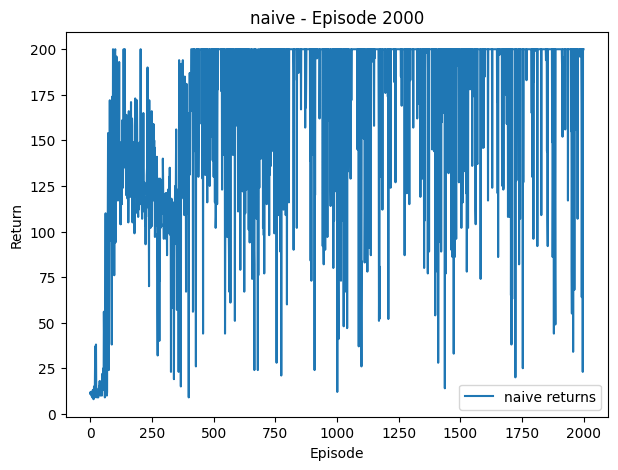

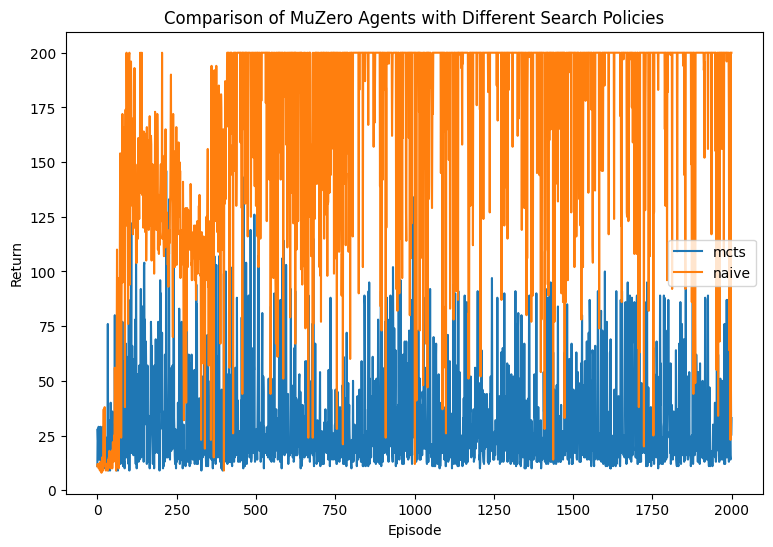

In [9]:
def train_with_search_policy(search_type='mcts'):
    """
    Trains a MuZero_Agent with the given `search_type` using
    your exact train-loop code. We only add reward logging/plotting.
    """
    # Hyper-parameters
    history_length = 3
    num_hidden = 50
    num_simulations = 20
    replay_capacity = 200
    batch_size = 32
    k = 5
    n = 10
    lr = 1e-3
    value_coef = 1
    reward_coef = 1

    # Environment
    raw_env = gym.make('CartPole-v0')
    num_obs_space = raw_env.observation_space.shape[0]
    num_actions = raw_env.action_space.n
    num_in = history_length * num_obs_space
    env = GymWrapper(raw_env, history_length)

    # Models
    representation_model = RepresentationNet(num_in, num_hidden).to(device)
    dynamics_model = DynamicsNet(num_hidden, num_actions).to(device)
    prediction_model = PredictionNet(num_hidden, num_actions).to(device)

    # Create the agent, attaching the chosen search policy.
    # (Assumes MuZero_Agent accepts an extra argument for search_type.)
    agent = Agent(num_simulations, num_actions, representation_model, dynamics_model, prediction_model, search_type).to(device)

    # Our runner and replay buffer.
    runner = LoggingEnvRunner(env)
    replay_buffer = BufferReplay(replay_capacity, num_actions)

    # Loss and optimizer
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(agent.parameters(), lr=lr)

    # Training loop
    for episode in range(2000):
        trajectory = runner.run(agent)
        replay_buffer.add_trajectories([trajectory])

        if len(replay_buffer) < 15:
            continue

        # Temperature scheduling (same as original)
        if episode < 250:
            agent.temperature = 1
        elif episode < 300:
            agent.temperature = 0.75
        elif episode < 400:
            agent.temperature = 0.65
        elif episode < 500:
            agent.temperature = 0.55
        elif episode < 600:
            agent.temperature = 0.3
        else:
            agent.temperature = 0.25

        # 16 mini-batch updates each episode
        for i in range(16):
            optimizer.zero_grad()

            data = replay_buffer.sample_batch(batch_size, k, n)

            # Network unroll input (flatten observations)
            representation_in = torch.stack(
                [torch.flatten(data[i]["obs"]) for i in range(batch_size)]
            ).to(device).to(dtype)

            actions = np.stack([np.array(data[i]["actions"], dtype=np.int64)
                                for i in range(batch_size)])
            rewards_target = torch.stack([torch.tensor(data[i]["rewards"])
                                          for i in range(batch_size)]).to(device).to(dtype)
            policy_target = torch.stack([torch.stack(data[i]["pi"])
                                         for i in range(batch_size)]).to(device).to(dtype)
            value_target = torch.stack([torch.tensor(data[i]["return"])
                                        for i in range(batch_size)]).to(device).to(dtype)

            loss = torch.tensor(0).to(device).to(dtype)

            # Initial step
            state, p, v = agent.initial_step(representation_in)
            policy_loss = mse_loss(p, policy_target[:, 0].detach())
            value_loss = mse_loss(v, value_target[:, 0].detach())
            loss += (policy_loss + value_coef * value_loss) / 2

            # k unroll steps
            for step in range(1, k+1):
                step_action = actions[:, step - 1]
                step_action = torch.from_numpy(step_action).to(device=device)
                state, p, v, rewards = agent.rollout_step(state, step_action)

                pol_loss = mse_loss(p, policy_target[:, step].detach())
                val_loss = mse_loss(v, value_target[:, step].detach())
                rew_loss = mse_loss(rewards, rewards_target[:, step-1].detach())

                loss += (pol_loss + value_coef * val_loss + reward_coef * rew_loss) / k

            loss.backward()
            optimizer.step()

        # Live plotting every 5 episodes
        if (episode + 1) % 5 == 0:
            clear_output(True)
            plt.figure(figsize=(7, 5))
            plt.plot(runner.episode_returns, label=f'{search_type} returns')
            plt.title(f'{search_type} - Episode {episode+1}')
            plt.xlabel('Episode')
            plt.ylabel('Return')
            plt.legend()
            plt.show()

    # Finally, return the entire list of returns so we can compare across runs
    return runner.episode_returns


# ---------------------------------------------------------------------
# Run training for each search policy and then compare final results.
# Each call uses the same code above but different `search_type`.
# ---------------------------------------------------------------------
all_results = {}
search_types = ['mcts', 'naive']

for s_type in search_types:
    print(s_type)
    returns = train_with_search_policy(s_type)
    all_results[s_type] = returns

# ---------------------------------------------------------------------
# Plot them all on one final chart (optional).
# ---------------------------------------------------------------------
plt.figure(figsize=(9, 6))
for s_type in search_types:
    plt.plot(all_results[s_type], label=s_type)
plt.title("Comparison of MuZero Agents with Different Search Policies")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()


# Comparison of the Search Policies and results

Run training for each search policy and then compare final results. Each call uses the same code above but different `search_type`.